In [ ]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#%% IMPORTING DATA
# Looping through files and saving file names
def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        #img = Image.open(filename,'r')
        #IMG = np.array(img)
        sample.append(filename)
    return sample

path1 = '/content/drive/MyDrive/Colab Notebooks/Br35H-Mask-RCNN/no/*.jpg'
path2 = '/content/drive/MyDrive/Colab Notebooks/Br35H-Mask-RCNN/yes/*.jpg'
path3 = '/content/drive/MyDrive/Colab Notebooks/Br35H-Mask-RCNN/pred/*.jpg'

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS
# Lableling
df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/Br35H-M...,Healthy
1,/content/drive/MyDrive/Colab Notebooks/Br35H-M...,Healthy
2,/content/drive/MyDrive/Colab Notebooks/Br35H-M...,Healthy
3,/content/drive/MyDrive/Colab Notebooks/Br35H-M...,Healthy
4,/content/drive/MyDrive/Colab Notebooks/Br35H-M...,Healthy


In [ ]:
#%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION)

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

In [ ]:
#%% CREATING THE CNN MODEL 

import keras
import tensorflow as tf
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tf.keras.optimizers import RMSprop

def build_model():

    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    #Cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                    

In [ ]:
#%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    #keras_model.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['acc'])
    # For minimum loss
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                          
    # For saving weights
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    # For tuning learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
    # For training
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255) # to reduce image variance

        # Normalization of train set
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '/content/drive/MyDrive/Colab Notebooks/Br35H-Mask-RCNN/TRAIN/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        # Normalization of Validation set
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '/content/drive/MyDrive/Colab Notebooks/Br35H-Mask-RCNN/VAL/*.jpg',
                                              
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)


Found 2941 validated image filenames belonging to 2 classes.
Found 327 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
295/295 [==============================] - 375s 1s/step - loss: 0.6186 - acc: 0.6518 - val_loss: 0.5328 - val_acc: 0.7248 - lr: 1.0000e-04
Epoch 2/50
295/295 [==============================] - 19s 63ms/step - loss: 0.4998 - acc: 0.7657 - val_loss: 0.4269 - val_acc: 0.8104 - lr: 1.0000e-04
Epoch 3/50
295/295 [==============================] - 19s 63ms/step - loss: 0.4093 - acc: 0.8266 - val_loss: 0.2990 - val_acc: 0.8899 - lr: 1.0000e-04
Epoch 4/50
295/295 [==============================] - 18s 63ms/step - loss: 0.2961 - acc: 0.8943 - val_loss: 0.1894 - val_acc: 0.9511 - lr: 1.0000e-04
Epoch 5/50
295/295 [==============================] - 18s 62ms/step - loss: 0.1877 - acc: 0.9364 - val_loss: 0.1315 - val_acc: 0.9633 - lr: 1.0000e-04
Epoch 6/50
295/295 [==============================] - 18s 62ms/step - loss: 0.1174 - acc: 0.9663 - val_l

In [ ]:
#%% CHEKING THE CROSS VALIDATION METRICS

def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.9816513657569885
Val_Acc Folder 1 = 0.9908257126808167
Val_Acc Folder 2 = 0.9938837885856628


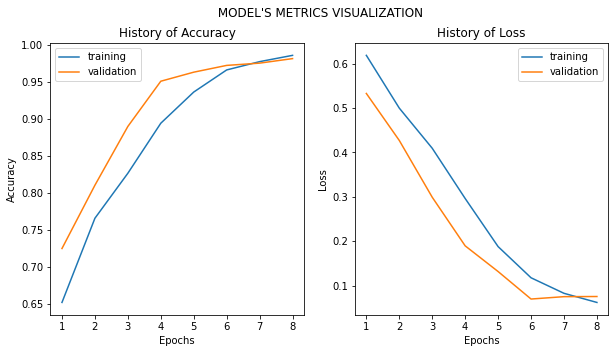

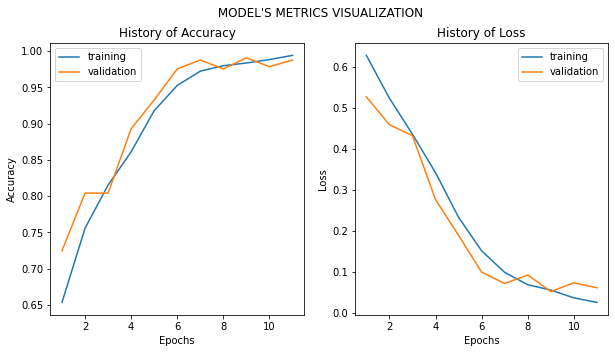

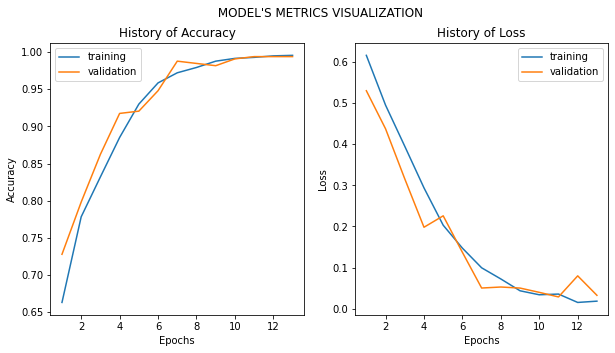

In [ ]:
#%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])

        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [ ]:
df_test.head()

,image
0,/content/drive/MyDrive/Colab Notebooks/Br35H-M...
1,/content/drive/MyDrive/Colab Notebooks/Br35H-M...
2,/content/drive/MyDrive/Colab Notebooks/Br35H-M...
3,/content/drive/MyDrive/Colab Notebooks/Br35H-M...
4,/content/drive/MyDrive/Colab Notebooks/Br35H-M...


In [ ]:
#%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('/content/Brain_model_best.h5')
keras_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])
#keras_model.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255.)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = '/content/drive/MyDrive/Colab Notebooks/Br35H-Mask-RCNN/TEST/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')
predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)

Found 60 validated image filenames.
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0
 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1]


In [ ]:
pred=[]
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy']


In [ ]:
#%% OBTAINING PREDICTIONS OF THE FIRST BATCH
    
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

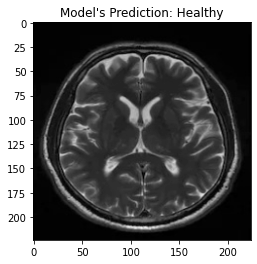

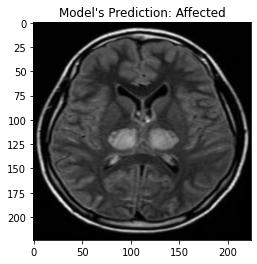

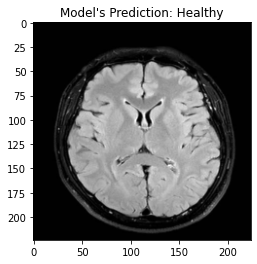

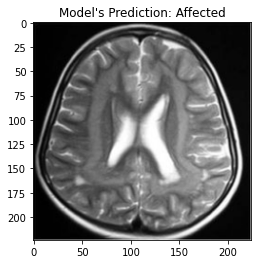

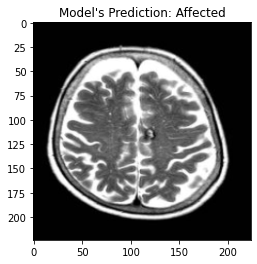

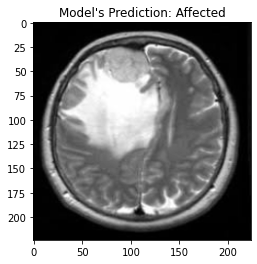

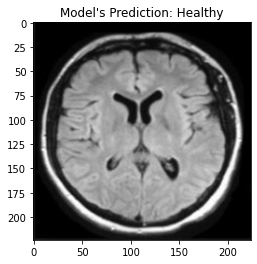

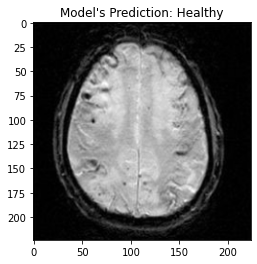

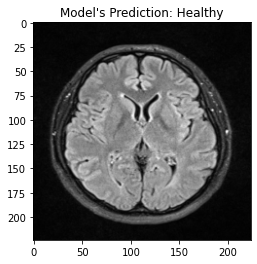

In [ ]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)